In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch

from monai import transforms
from monai.data import NibabelReader, NibabelWriter, Dataset, DataLoader, decollate_batch
from monai.transforms.utils import allow_missing_keys_mode

import nibabel as nib
from matplotlib import pyplot as plt

In [4]:
# root_dir = '/mnt/nfs/projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'
root_dir = '/mnt/nfs/home/liglesias/data_acdc'
testing_dir = os.path.join(root_dir, "masks_testing")

In [5]:
def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

testing_files = list_nifti_files(testing_dir)
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing


In [6]:
testing_files[:2]

['/mnt/nfs/home/liglesias/data_acdc/masks_testing/patient101_frame01_gt.nii.gz',
 '/mnt/nfs/home/liglesias/data_acdc/masks_testing/patient101_frame14_gt.nii.gz']

(232, 256, 10)
(232, 256, 10)
(216, 256, 8)
(216, 256, 8)
(216, 256, 9)


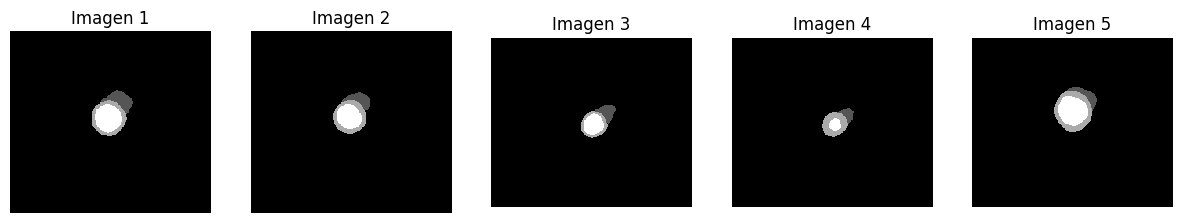

In [7]:
images = [nib.load(file) for file in testing_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img.get_fdata()[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [8]:
preprocessing = transforms.Compose([
    transforms.LoadImaged(keys=["image"], reader=NibabelReader()),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"], track_meta=True),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Spacingd(keys=["image"], pixdim=(1.52344, 1.52344, None), mode='nearest'),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=(None, 128, 128)),
    transforms.Resized(keys=["image"], spatial_size=(12, None, None), mode="nearest"),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
])

postprocessing = transforms.Compose([
    transforms.AsDiscreted(keys=["pred"], argmax=True),
    transforms.EnsureTyped(keys=["pred"], dtype=int),
    transforms.Invertd(keys=["pred"], transform=preprocessing, orig_keys="image"),
    transforms.SaveImaged(keys=["pred"], 
                          meta_keys=["image_meta_data"], 
                          output_dir="reconstructed_masks_testing", 
                          output_postfix="reconstructed", 
                          output_ext=".nii.gz",
                          data_root_dir=root_dir,
                          separate_folder=False),
])

In [9]:
test_data_dicts = [{"image": file} for file in testing_files][0:1]
orig_img = nib.load(test_data_dicts[0]["image"])
print(orig_img.shape)

(232, 256, 10)


In [10]:
pre_image = preprocessing(test_data_dicts[0])
pre_image['image'].shape

torch.Size([4, 12, 128, 128])

In [11]:
pre_image['pred'] = pre_image['image'] #model(pre_image['image'])
post_image = postprocessing(pre_image)
post_image['pred'].shape

2025-01-31 23:41:44,642 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient101_frame01_gt_reconstructed.nii.gz


torch.Size([1, 232, 256, 10])

In [12]:
argmax = transforms.AsDiscreted(keys=["image"], argmax=True)

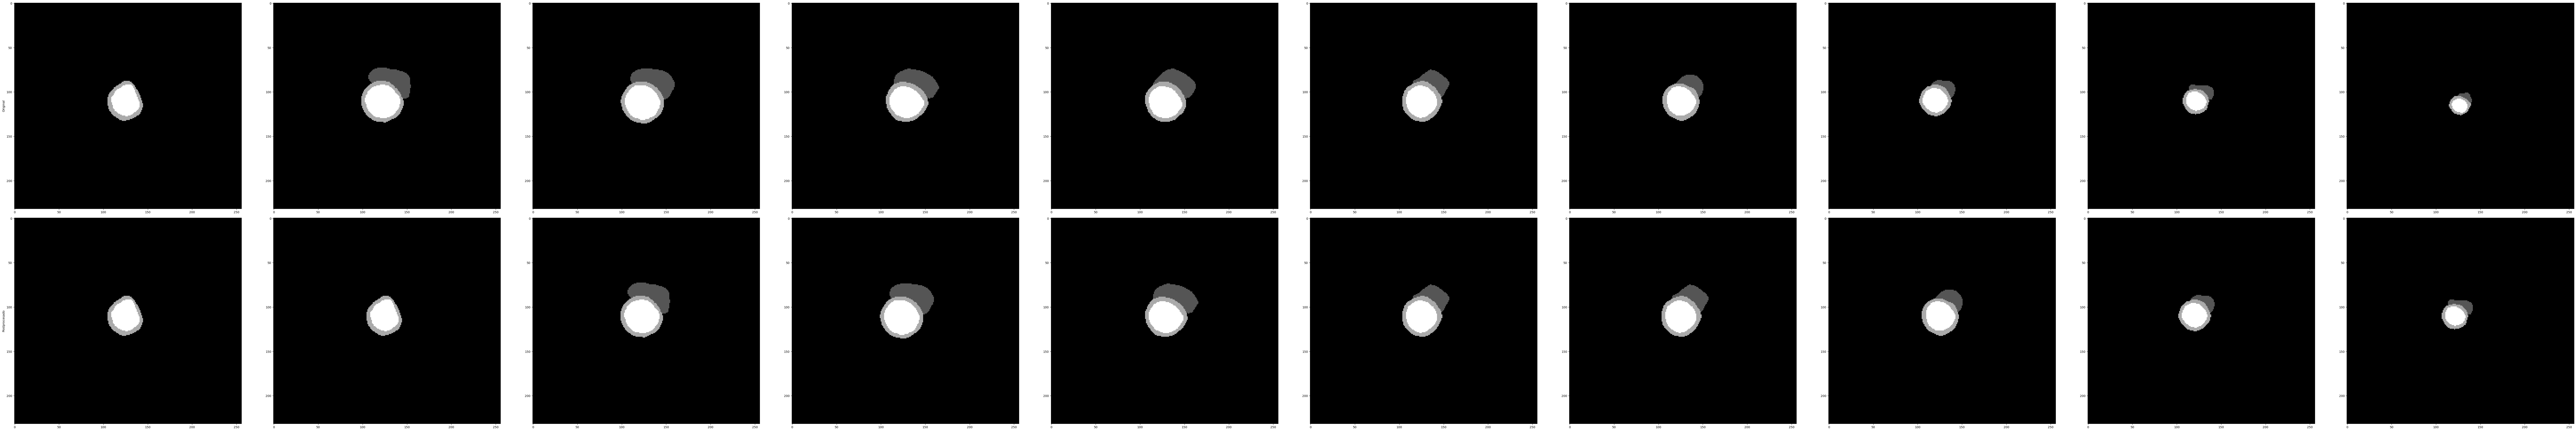

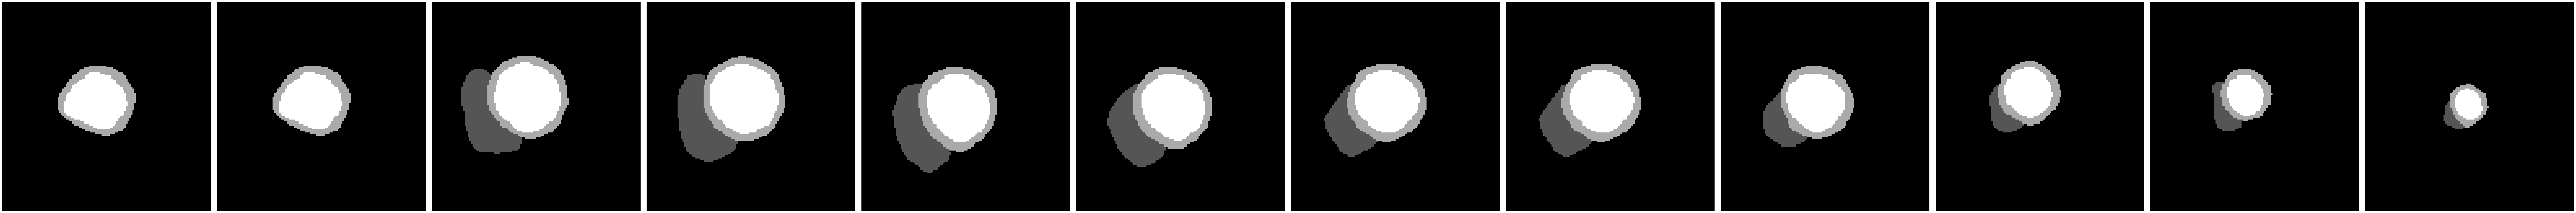

In [13]:
fig, axes = plt.subplots(2, post_image['pred'].shape[-1], figsize=(120, 20))
for i in range(post_image['pred'].shape[-1]):
    axes[0,i].imshow(orig_img.get_fdata()[:, :, i], cmap="gray", interpolation='none')
    axes[1,i].imshow(post_image['pred'][0, ..., i], cmap="gray", interpolation='none')
axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Postprocesado")
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, pre_image['image'].shape[1], figsize=(120, 10))
for i, ax in enumerate(axes):
    ax.imshow(argmax(pre_image)['image'][0,i], cmap="gray", interpolation='none')
    ax.set_ylabel("Preprocesado")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [14]:
from custom_autoencoder import Autoencoder

In [15]:
model_weights = "/mnt/nfs/projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/autoencoder_model.pth"

trained_model = torch.load(model_weights)
trained_model.to("cuda")

model = Autoencoder()
model.load_state_dict(trained_model.state_dict())

model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)

In [16]:
val_data_dicts = [{"image": file} for file in testing_files]
val_dataset = Dataset(data=val_data_dicts, transform=preprocessing)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                            num_workers=1, persistent_workers=True)

In [ ]:
with torch.no_grad():

    for i, batch in enumerate(val_dataloader):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing(sample)
            print(reconstructed_mask['pred'].shape)
        # break

2025-01-20 17:31:21,989 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient101_frame01_gt_reconstructed.nii.gz
torch.Size([1, 232, 256, 10])
2025-01-20 17:31:22,223 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient101_frame14_gt_reconstructed.nii.gz
torch.Size([1, 232, 256, 10])
2025-01-20 17:31:22,478 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient102_frame01_gt_reconstructed.nii.gz
torch.Size([1, 216, 256, 8])
2025-01-20 17:31:22,708 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient102_frame13_gt_reconstructed.nii.gz
torch.Size([1, 216, 256, 8])
2025-01-20 17:31:22,932 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient103_frame01_gt_reconstructed.nii.gz
torch.Size([1, 216, 256, 9])
2025-01-20 17:31:23,170 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_testing/patient103_frame11_gt_reco